## Astronomy 406 "Computational Astrophysics" (Fall 2017)

### Week 2: Interpolation and Numerical Derivatives

<b>Reading:</b> notes below, as well as $\S$[3.0-3.6](https://umich.instructure.com/files/2342968/download?download_frd=1) and $\S$[5.7](https://umich.instructure.com/files/2392548/download?download_frd=1) of [Numerical Recipes](http://numerical.recipes).

#### Interpolation of tabulated data

All data available to us are presented in a tabulated form. Even when we look at a line on a plot of $y$ vs. $x$, it is not a continuous function but a set of discrete data points (an array of values $x_i$ and $y_i$, for $i=0, N$, in computer representation).

Sometimes it is desirable to know the expected value of $y$ at a point between the tabulated $x_i$.  Such an expectation function is called interpolating function, and the process is called interpolation.

Let's look at an example. Remember to execute each cell.  First, set up the necessary libraries.

In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 90
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

Now let's create a simple dataset and plot it.

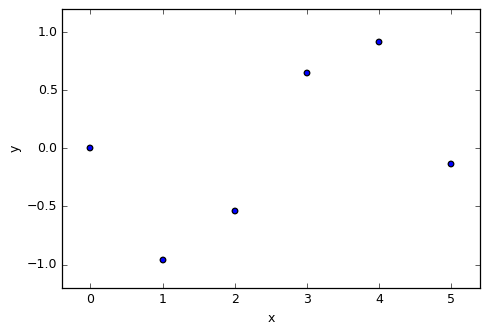

In [2]:
x = np.array([0, 1, 2, 3, 4, 5])
y = np.sin(5.*x)

plt.xlim(-0.4, 5.4)
plt.ylim(-1.2, 1.2)
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x, y)
plt.show()

Is there a unique way to connect the points? Your eye may guide you to a smooth curve going up and down, for example using straight lines.  Let's plot it below.

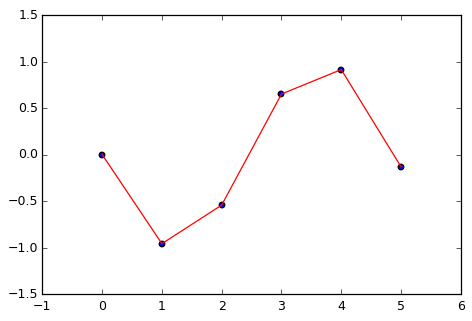

In [3]:
plt.plot(x, y, 'r-')
plt.scatter(x, y)
plt.show()

Now let's plot the real function used to generate these points.

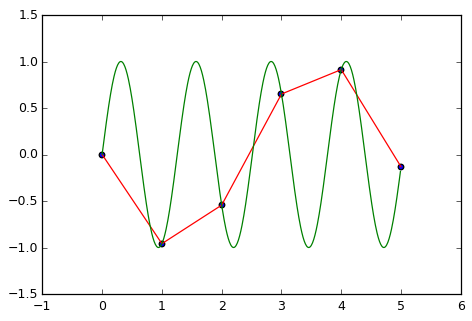

In [4]:
plt.scatter(x, y)
plt.plot(x, y, 'r-')

# overplot the generating function
xa = np.arange(0, 5, 0.01)
plt.plot(xa, np.sin(5.*xa), 'g-')
plt.show()

#Here we do interpolation because we are trying to find the UNDERLYING function, w/o applying any kind of model

We can see that we missed a lot of ups and downs!  The point of this exercise is to illustrate that there is no unique way to connect discrete data points.  So, what should we do in practice?

The answer depends on what we know and what we want to achieve.  If we know absolutely nothing about the origin of our data points (how they were obtained, what they represent), then we go for straight lines as in the example above.  It is called 'linear interpolation' and is the most basic, and robust, way of estimating the value of $y$ between the data points.

However, if we know that the data represent measurements of some fairly predictable variable, which should vary smoothly with $x$, then we can use higher-order interpolation schemes.  The most common is 'spline interpolation'.

Let's use functions [interpolate.interp1d](http://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html) and [interpolate.UnivariateSpline](http://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.UnivariateSpline.html) provided by the SciPy package.

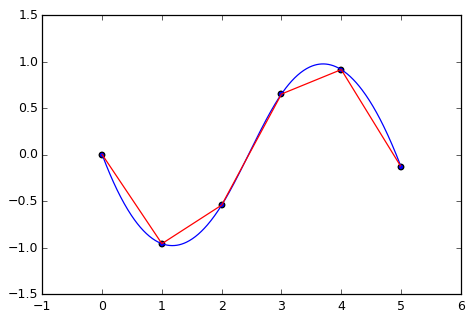

In [5]:
yint = interpolate.interp1d(x, y, kind='linear')
yspline = interpolate.UnivariateSpline(x, y, s=0)

plt.scatter(x, y)
plt.plot(xa, yspline(xa), 'b-', label='spline')
plt.plot(xa, yint(xa), 'r-', label='linear')
plt.show()

#Spline is letting us be able to find derivatives, which we can't find with jagged fits!

The red line corresponds to the unique first-order (linear) polynomial that goes through the all data points exactly.  You can also use the third-order polynomial by switching the <t>kind</t> value to <t>cubic</t>.

The blue line corresponds to a spline function that guarantees a continuous second derivative of the interpolating function.  The idea behind splines is to add a cubic polynomial to a linear function, such that $y'' = d^2y/dx^2$ varies linearly between each neighbor pair of data points $x_i$ and $x_{i+1}$, and the first derivative $y' = dy/dx$ is continuous across the data points.  It turns out that there is an (almost) unique solution that satisfies these requirements.  Almost unique because $y''$ needs to be specified at the two end points; these are usually set to zero, enforcing linear interpolation beyond the range of available data.  It makes sense - we should never use non-linear extrapolation.

The parameter $s$ in the UnivariateSpline function above allows a smoother fit, which passes acceptably close to the data points, but not necessarily exactly through them.  The larger $s$, the larger an acceptable deviation:
$\sum_i (y_i-\mathrm{spl}(x_i))^2 <= s$.
We will come back to this metric when we discuss fitting a model to a dataset.

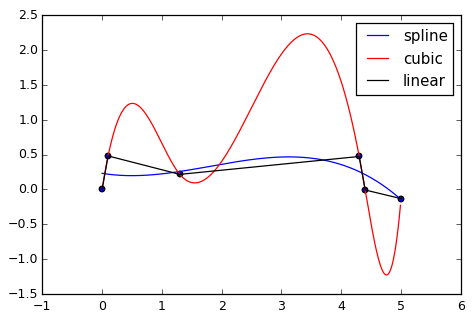

In [6]:
x = np.array([0, .1, 1.3, 4.3, 4.4, 5])
y = np.sin(5.*x)

yint = interpolate.interp1d(x, y, kind='cubic')
yspline = interpolate.UnivariateSpline(x, y, s=10)

plt.scatter(x, y)
plt.plot(xa, yspline(xa), 'b-', label='spline')
plt.plot(xa, yint(xa), 'r-', label='cubic')
plt.plot(x, y, 'k', label = 'linear')
plt.legend()
plt.show()

#Lesson: Higher-order is NOT better than linear, it depends a lot...knowing nothing, and just wanting derivs, linear is the most robust!

The UnivariateSpline routine first calculates the fixed coefficients corresponding to the values of $y''_i$ and stores them as an array.  This completely specifies a simple (third-order in $x$) analytical function that describes our data throughout the whole interval of data.  We can then evaluate this function at as many locations as we need without having to repeat the polynomial fit, as in the interp1d routine.

An additional advantage of using spline interpolation is that we can integrate or differentiate the interpolating function analytically, and similarly evaluate $\int y(d) dx$ or $dy/dx$ at any location.  Without any extra calculation!  In fact, it is one of the most convenient ways to evaluate a derivative of a function known only at discrete points.  The UnivariateSpline routine provides the functions to do it.

In [7]:
yspline = interpolate.UnivariateSpline(x, y, s=0)
print yspline.derivatives(4.5)

[ -0.48354763  -4.46677722   8.11587825  75.36478585]


We can obtain spline coefficients using the method <b>get_coeffs</b>:

In [8]:
print yspline.get_coeffs()

#Go to manual pages, but can also refer to Numerical Recipes section perhaps

[  7.81459557e-17   2.38315607e+00  -3.33494828e+00   6.41998711e+00
  -2.23509578e+00  -1.32351750e-01]


Lets look at another data set, which we will use later next week.  The data file is located in 'Canvas/Files/Data files'.  Download it and place in the same folder as this Notebook.

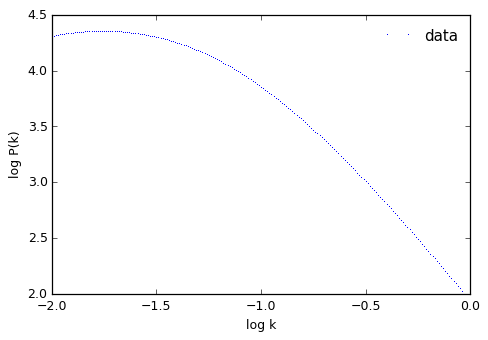

In [9]:
logk_data, logPk_data = np.loadtxt("DataFiles/pk2.dat", unpack=True)

plt.xlim(-2, 0)
plt.ylim(2, 4.5)
plt.xlabel('log k')
plt.ylabel('log P(k)')
plt.plot(logk_data, logPk_data, ',', label='data')
plt.legend(frameon=False)
plt.show()

<b>Exercise 1:</b> Create a spline interpolating function for this data set.  Evaluate $P(k)$ and $dP/dk$ it at $k = -0.47$ and $k = 0.52$.  Note that the data are provided as logarithms base-10 for both $k$ and $P(k)$.  You need to transform them accordingly.

Finding d(logP) / d(logk)


In [10]:
yspline = interpolate.UnivariateSpline(10**logk_data,10**logPk_data, s=0)


k_vals = np.array([0.52])   #-0.47 won't work, would have to extrapolate for it...
for i in k_vals:
    print i, yspline.derivatives(i)   #In yspline.deriv = [a,b,c,d] = [y(x), derivative, higher order terms?]

0.52 [  358.72341528 -1477.10559088  8647.36891536  8690.38233987]


Interpolation is also very useful for inverting functional relations, or calculating the inverse function. It is a very convenient feature of the numerical method, compared to the more complicated analytical way. Look at this example:

In [11]:
xs = np.arange(-np.pi/2., np.pi/2., 0.1)
ys = np.sin(xs)
print 'use %d points for interpolation'%( len(xs) )

xint = interpolate.interp1d(ys, xs, kind='cubic')

for y in [ 0., 0.5, 0.99 ]:
    x = xint(y)
    print 'interp = %.6f  arcsin = %.6f'%( x*180./np.pi, np.arcsin(y)*180./np.pi )

use 32 points for interpolation
interp = 0.000004  arcsin = 0.000000
interp = 30.000007  arcsin = 30.000000
interp = 81.890925  arcsin = 81.890386


#### Differentiation

Calculating a derivative may seem as a straightforward task.  Choose a small offset of the independent variable, $dx = h$, and calculate $f'(x) = {f(x+h)-f(x) \over h}$.  There many issues and pitfalls in such an approach.

There are both sources of error in this equation, truncation error and roundoff error.  The truncation error comes from the higher terms in the Taylor series expansion: 
$f(x+h) = f(x) + h f'(x) + {1\over 2}h^2 f''(x) + {1\over 6}h^3 f'''(x) + ...$, so

${f(x+h)-f(x) \over h} = f'(x) + {1\over 2}h f''(x) + ...$, and

$e_t \sim |h f''(x)|$.

The roundoff error comes mainly from the accuracy of calculation of $f(x)$: $\epsilon_r \sim \epsilon_f |f(x)/h|$, where $\epsilon_f$ is the fractional error of calculation of $f(x)$.  

The optimal choice of $h$ minimizes the sum $e_t + e_r$, which gives
$h \sim \sqrt{\epsilon_f f \over f''} \approx \sqrt{\epsilon_f} x_c$.
Here $x_c$ is the characteristic scale over which function $f(x)$ varies, which can often be taken as $x_c = x$.  With this choice of $h$, the fractional error of the derivative calculation is
$(e_r + e_t)/|f'| \sim \sqrt{\epsilon_f} \sqrt{f f''/f'^2} \sim \sqrt{\epsilon_f}$.
If a typical error of evaluting $f(x)$ is 1%, then the error of the derivative is already 10%.

***So there is a min value for h that mins the error(but is not the smallest possible value)

<b>Exercise 2:</b> Show analytically, following a similar derivation, that a symmetric derivative $f' = {f(x+h)-f(x-h) \over 2h}$ has an optimal choice of $h \sim \epsilon_f^{1/3} x_c$ and the fractional error of $(e_r + e_t)/|f'| \sim {\epsilon_f}^{2/3}$.  This is a significantly better scaling when ${\epsilon_f} \lesssim 0.01$. Predict the optimal choice of $h$ given what you know about computers and functional accuracy limits.

f(x+h) = f(x) + h * f'(x) + 1/2 h^2 * f''(x) + h^3/6 * f'''(x) 
f(x-h) = f(x) - h*f'(x) + 1/2 h^2 * f''(x) - h^3/6 * f'''(x)

f(x+h) - f(x-h) =  h * (f'(x) + f'(x)) + h^3 / 3 * f'''(x)
[f(x+h) - f(x-h)] / (2h) = f'(x) + h^2 / 6 * f'''(x)

e_t ~ |h^2 * f'''(x)|
e_r ~ e_f |f(x) / h|

e_t + e_r min means d/dx[e_t + e_r] = 0
e_t + e_r = eps_f * (f(x) / h) + h^2 * f'''(x)

d/dx(e_t) = d/dx(e_r)
eps_f * f /h^2 = 2h * f'''(x)

h^3 = eps_f * f / [2 * f'''(x)] -> h = {[eps_f * f] / [2 * f'''(x)]}^(1/3)

x_c is |f / df/dx| by dimensional analysis
x_c^3 = f / f'''(x) -> f'''(x) = f / x_c^3
h = {[eps_f * f] / [2 * f / x_c^3]}^(1/3)
h = {[eps_f * x_c^3] / 2}^(1/3) = (eps_f)^(1/3) * x_c



***Lessons: 
-Use pen and paper to write down even numerical problems
-You can modify algorithms or expressions to make the computer do half the work but twice the accuracy
-Good to go through equations and know where dependencies come from


<b>Exercise 3:</b> Write a routine to calculate the derivative $dP/dk$ from Exercise 1 for a given value of $h$, and output the result for a sequence of $h = 10^{-8}, 10^{-7}, ..., 10^{-1}$.  Plot the sequence of $dP/dk$ as a function of $h$.  Estimate the optimum value of $h$ for your scheme and add it to your plot.  Does this value correspond to any feature in the plot?

[-1477.10555325 -1477.10515762 -1477.10126714 -1477.06235388 -1476.67320795
 -1472.78045802 -1433.84511994 -1133.73344825] [-1477.10559872 -1477.10559048 -1477.10559085 -1477.10559073 -1477.10557639
 -1477.10414248 -1477.04237637 -1584.14370502]


[]

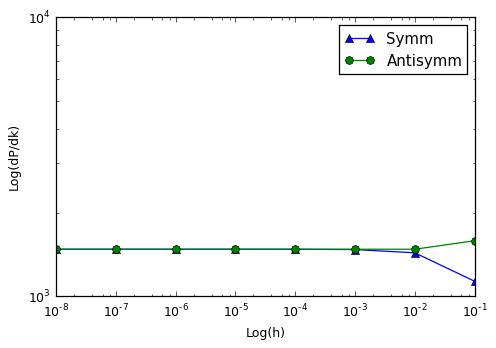

In [12]:
#Setup we have done, I forget....
#%matplotlib inline
#from matplotlib import rcParams
#rcParams["savefig.dpi"] = 90
#import numpy as np
#import matplotlib.pyplot as plt
#from scipy import interpolate

#Calculate derivative of dP/dk for k = 0.52 for a given h using two methods
#Estimate the optimum h for your scheme and add it to the plot
#Plot dP/dk (h)
#We have logk_data, logPk_data, yspline(10**k, 10**P); We should get ~-1477.1055 at k = 0.52


k = 0.52
h = np.array([1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
#Should have used h = np.logspace(-8, -1, 8)

#First need
# f'(x) = (f(x+h) + f(x)) / (h)
d_symm = (yspline(k+h) - yspline(k)) / (h)
    
# f'(x) = (f(x+h) - f(x-h)) / (2h)   
d_anti = (yspline(k+h) - yspline(k-h)) / (2*h)


print d_symm, d_anti

plt.plot(h, np.abs(d_symm), marker = '^', label = 'Symm')
plt.plot(h, np.abs(d_anti), marker = 'o', label = 'Antisymm')

plt.legend()
plt.xlabel('Log(h)')
plt.ylabel('Log(dP/dk)')
plt.loglog()



Let's take a discrete representation of a Gaussian function and interpolate it.  This will be the function that we will then differentiate (and later integrate).

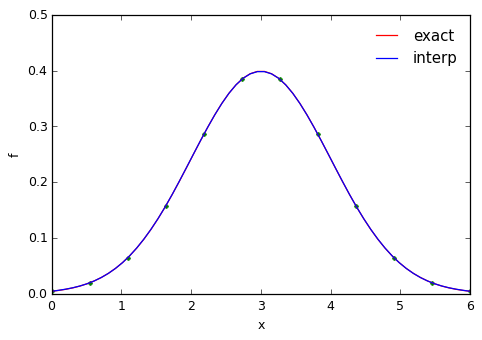

In [13]:
mu = 3.
sig2 = 1.

# Gaussian function
def fg(x):    
    return np.exp(-(x-mu)**2/sig2/2.)/np.sqrt(2.*np.pi*sig2)

# derivative of Gaussian function
def dfg(x):   
    return (mu-x)/sig2*fg(x)

xx = np.linspace(0,6,12)
yy = fg(xx)
yint = interpolate.interp1d(xx, yy, kind='cubic')
plt.xlabel('x')
plt.ylabel('f')
plt.xlim(0, 6)
plt.ylim(0, 0.5)
plt.plot(xx, yy, 'g.')
xlin = np.linspace(0,6,60)
plt.plot(xlin, fg(xlin), 'r-', label='exact')
plt.plot(xlin, yint(xlin), 'b-', label='interp')
plt.legend(frameon=False)
plt.show()

Now we write two routines to calculate the derivative $df/dx$ for a given value of $h$, the simple one-sided one and the better symmetric one, and output the result for a sequence of $h = 10^{-15}, 10^{-14}, ..., 10^{0}$.

exact answer = 0.241970724519
log steps = [-15. -14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.]
ratio of one-sided = [ 0.9176507   1.03235704  1.00023926  1.00023926  0.99999838  0.99999953
  1.0000001   1.          1.          1.          1.          1.
  0.99999967  0.99996658  0.99658855]
ratio of symmetric = [ 0.97500387  1.01515109  0.99966573  1.00018191  0.99999265  0.99999953
  1.0000001   0.99999999  1.          1.          1.          1.
  0.99999967  0.99996667  0.99667166]


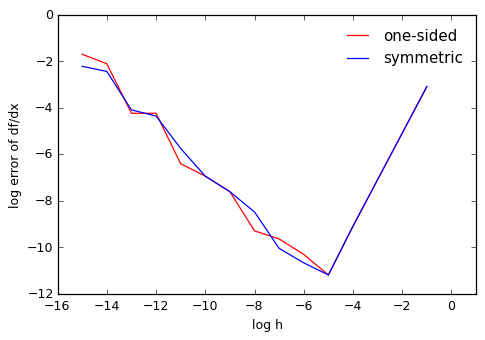

In [14]:
def diff1(f,x,h):
    return (f(x+h)-f(x))/h

def diff2(f,x,h):
    return (f(x+h)-f(x-h))/(2.*h)

x = 2.
loghh = np.arange(-15.,0.)
d1 = [diff1(fg, x, 10.**logh) for logh in loghh]
d2 = [diff2(fg, x, 10.**logh) for logh in loghh]
de = dfg(x)
print "exact answer =",de
print "log steps =",loghh
print "ratio of one-sided =",d1/de
print "ratio of symmetric =",d2/de

plt.xlabel('log h')
plt.ylabel('log error of df/dx')
plt.xlim(-16, 1)
plt.ylim(-12, 0)
plt.plot(loghh, np.log10(np.fabs(d1-de)), 'r-', label='one-sided')
plt.plot(loghh, np.log10(np.fabs(d2-de)), 'b-', label='symmetric')
plt.legend(frameon=False)
plt.show()

Let's estimate the optimum value of $h$ in the case of symmetric deriative.  The value of the function $f$ and its characteristic scale $x_c$ are both of order unity.  Therefore, $h \sim \epsilon_f^{1/3} \sim 10^{-5}$, for machine accuracy of $\epsilon_f \sim 10^{-15}$.  The plot above confirms that this value corresponds to minimum error of the derivative.

Now let's use the linearly interpolated function.  Now the accuracy of the function calculation is lower.

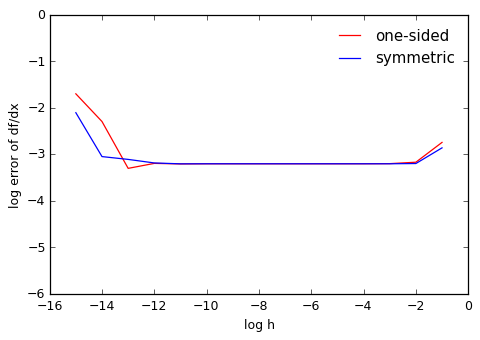

In [15]:
di1 = [diff1(yint, x, 10.**logh) for logh in loghh]
di2 = [diff2(yint, x, 10.**logh) for logh in loghh]

plt.xlabel('log h')
plt.ylabel('log error of df/dx')
plt.ylim(-6, 0)
plt.plot(loghh, np.log10(np.fabs(di1-de)), 'r-', label='one-sided')
plt.plot(loghh, np.log10(np.fabs(di2-de)), 'b-', label='symmetric')
plt.legend(frameon=False)
plt.show()

**Exercise 4**:

Explain what this figure means and why this figure differs from the one above using the analytical representation of the derivative. Would you choose the optimal value for $h$ that you predicted in Exercise 2 and that you showed to be true in the previous figure? Why or Why not? How would you re-do this second part to have a much smaller error on df/dx? Can you ever reach an error for the interpolated data that is as small as the analytical result?

Of course we really want to know the derivative everywhere and to high accuracy, which means that we need both $h \rightarrow 0$ and and small error. How do we do this?

First, note the following representation of a symmetric estimate of the derivative (which be shown separately as an exercise):

Note: f_h = f(x+h), f_-h = f(x-h); This is for only odd powered derivatives remain (as seen)

${f_h - f_{-h} \over {2h}} = f^{'}_0 + \sum\limits_{j=1}^{\infty} {f_0^{(2j+1)} \over (2j+1)!}h^{2j}$ 

In shorthand, we can re-write the above representation as (as a1 = third deriv, a2 = fifth deriv, etc):

$D(h) = D(0) + a_1h^2 + a_2h^4 + a_3h^6 + ...$ 

where $D(h)$ is the calculated derivative, D(0) is the exact value in the limit $h \rightarrow 0$ and the $a_i$s are simply other terms independent of $h$. In this equation, what is the limiting factor in the accruacy on the derivative at $D(0)$? In other words, what is the *order* in  terms of h?

Now, let $h$ shrink by a factor of 2:

$D(h/2) = D(0) + {a_1h^2 \over 4} + {a_2h^4 \over 16} + {a_3h^6 \over 64} + ...$ 

We can eliminate the term with $a_1$ by combining the above two equations:

$D(h/2) + {D(h/2) - D(h) \over 3} = D(0) -{a_2h^4 \over 4 } - {5a_3h^6 \over 16}$

Now what *order* is D(0)?


The best way to obtain an accurate solution to the derivative in the limit $h \rightarrow 0$ is to extend the above logic, which is called **Richardson's deferred approach to the limit**, or **Richardson's method** for short.  The idea is to calculate a progression of $f'_i(x)$ [symmetric approach] at several decreasing values of $h_i$ [eg. Halving h], starting with a fairly large value $h \sim 0.1 x_c$, and then extrapolate the result to $h \rightarrow 0$.  The extrapolation is done as an extension of an interpolating function going through the values $f'_i$.  The error of $f'$ is estimated from the last difference of the approximations.  We continue iterating until we reach required accuracy.

Consult $\S$[5.7](https://umich.instructure.com/files/2392548/download?download_frd=1) in <i>Numerical Recipes</i> for an efficient implementation of this method.

### Homework 1 (due Tuesday, Sep 19, 9am)

Write your own implementation of Richardson's method as a function that takes two arguments: the name of a user-defined function and the point at which to differentiate it. Calculate the same derivative $dP/dk$ as in Exercise 3.  Make a plot to compare your results with those from Exercise 3.

Plot:

D(h) or f'(x) |_
                h
                
Plot should look like 

   .
  .
_.

Take point, extrapolate out function, and try to calculate point. If difference between two consec points is less than what we want, then say ok, we got it. If result differs by more than accuracy, then try again.


<i>Please submit your homework as an IPython notebook like this.</i>